<a href="https://colab.research.google.com/github/velasoka-repo/EVA4/blob/master/Session-12/EVA4_S12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Github Link](https://github.com/velasoka-repo/EVA4/tree/master/Session-12)

# Google Drive Mount

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

#add working directory into syspath
EVA4_PATH = "/content/gdrive/My Drive/Colab Notebooks/EVA4/Session-12"
import sys
if not EVA4_PATH in sys.path:
  sys.path.append(EVA4_PATH)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Download Image

In [0]:
#!/usr/bin/python3
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
    # Download the file from the URL
zipresp = urlopen(zipurl)
    # Create a new file on the hard drive
tempzip = open("/tmp/tempfile.zip", "wb")
    # Write the contents of the downloaded file into the new file
tempzip.write(zipresp.read())
    # Close the newly-created file
tempzip.close()
    # Re-open the newly-created file with ZipFile()
zf = ZipFile("/tmp/tempfile.zip")
    # Extract its contents into <extraction_path>
    # note that extractall will automatically create the path
zf.extractall(path = '/opt/')
    # close the ZipFile instance
zf.close()

# Python Module Import & device

In [14]:
import utils.data as data
import utils.transform as tf
import model.nn2 as nn2
import utils.torch_util as util
import utils.visualize as view
import utils.runner as network

#device
device = util.device()
print(f"Device: {device}")

Device: cuda


# Read TinyImageNet Data

In [15]:
data_path = f"/opt/tiny-imagenet-200"

# read tinyimagenet data
img_dataset = data.LoadImage(root_path=data_path)
mean, std = util.normalized_mean_std(img_dataset.mean, img_dataset.std)

Total time taken to load image: 24.79 seconds


# Create Train & Test dataset

In [0]:
import torch
torch.manual_seed(6)
torch.cuda.manual_seed(6)

tf_util = tf.torch_transform()
train_compose_transforms = tf.compose_transforms(tf_util.RandomHorizontalFlip(p=0.5), tf_util.RandomCrop(size=64, padding=4, padding_mode="edge"), tf_util.ToTensor(), tf_util.Normalize(mean=mean, std=std))
train_dataset = data.ImageDataset(dataset=img_dataset.train_data, labels=img_dataset.train_labels,
                                  transforms=train_compose_transforms)

test_compose_transforms = tf.compose_transforms(tf_util.ToTensor(), tf_util.Normalize(mean=mean, std=std))
test_dataset = data.ImageDataset(dataset=img_dataset.test_data, labels=img_dataset.test_labels,
                                  transforms=test_compose_transforms)

# Create Train & Test Dataloader

In [0]:
torch.manual_seed(6)
torch.cuda.manual_seed(6)

kwargs = {'pin_memory': True, 'num_workers': 4}
train_loader = data.TinyImageNetDataLoader(dataset=train_dataset, batch_size=500, shuffle=True, **kwargs).dataloader
test_loader = data.TinyImageNetDataLoader(dataset=test_dataset, batch_size=500, shuffle=False, **kwargs).dataloader

# Create Model & Summary

In [18]:
torch.manual_seed(6)
torch.cuda.manual_seed(6)

model = nn2.resnet18(num_classes=200).to(device)
util.model_summary(model=model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

# Load Model state_dict

In [0]:
trained_model_path = util.drive_path(filename="tiny-imagenet-resnet18.pt", folder="Session-12") 
if trained_model_path:
    state_dict = util.load_model(path=trained_model_path)
    model.load_state_dict(state_dict=state_dict)

# Create Optimizer, loss function, Scheduler

In [0]:
# create optimizer, loss fn, scheduler
criterion = util.loss_fns().CrossEntropyLoss()
sgd_optimizer = util.optimizer().SGD(params=model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.1e-5)
scheduler = util.scheduler().ReduceLROnPlateau(optimizer=sgd_optimizer, mode="min", patience=10, verbose=True,
                                                min_lr=0.5e-6, factor=0.125)

# Train & Test Run

In [21]:
# train & test
epochs = 50
train_accuracy = []
test_accuracy = []
max_train_accuracy_so_far = 0
max_test_accuracy_so_far = 0
for epoch in range(1, epochs + 1):
    print(f"\nEPOCH: {epoch}")
    train_acc = network.train(model=model, data_loader=train_loader, optimizer=sgd_optimizer, criterion=criterion,
                              device=device)
    test_acc = network.test(model=model, data_loader=test_loader, device=device)
    scheduler.step(100 - test_acc)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    if max_test_accuracy_so_far < test_acc:
        max_test_accuracy_so_far = test_acc
        print(f"\n***Test Accuracy is greater than previous max accuracy. Saving model on epoch: {epoch}")
        util.save_model(model=model, path=trained_model_path)

    #early stopping
    if test_acc >= 50:
      break

  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 1


Batch: 139, loss: 1.81, Train Accuracy: 61.35 [42944/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.36s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 1

EPOCH: 2


Batch: 139, loss: 1.56, Train Accuracy: 67.81 [47465/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 2

EPOCH: 3


Batch: 139, loss: 1.13, Train Accuracy: 70.23 [49159/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 4


Batch: 139, loss: 1.07, Train Accuracy: 72.18 [50524/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 4

EPOCH: 5


Batch: 139, loss: 1.05, Train Accuracy: 74.40 [52077/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 5

EPOCH: 6


Batch: 139, loss: 1.02, Train Accuracy: 76.92 [53847/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 6

EPOCH: 7


Batch: 139, loss: 1.04, Train Accuracy: 78.56 [54993/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 8


Batch: 139, loss: 0.87, Train Accuracy: 80.49 [56341/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 9


Batch: 139, loss: 0.79, Train Accuracy: 82.66 [57864/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 10


Batch: 139, loss: 0.66, Train Accuracy: 84.60 [59217/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.36s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 10

EPOCH: 11


Batch: 139, loss: 0.61, Train Accuracy: 86.06 [60244/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 12


Batch: 139, loss: 0.53, Train Accuracy: 87.63 [61342/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.36s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 12

EPOCH: 13


Batch: 139, loss: 0.44, Train Accuracy: 89.04 [62330/70000]: 100%|██████████| 140/140 [03:10<00:00,  1.36s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 13

EPOCH: 14


Batch: 139, loss: 0.38, Train Accuracy: 89.89 [62924/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 14

EPOCH: 15


Batch: 139, loss: 0.41, Train Accuracy: 91.16 [63814/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 16


Batch: 139, loss: 0.28, Train Accuracy: 92.38 [64666/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 17


Batch: 139, loss: 0.23, Train Accuracy: 93.15 [65208/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.36s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 17

EPOCH: 18


Batch: 139, loss: 0.23, Train Accuracy: 93.96 [65772/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 18

EPOCH: 19


Batch: 139, loss: 0.23, Train Accuracy: 94.47 [66127/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 19

EPOCH: 20


Batch: 139, loss: 0.24, Train Accuracy: 95.17 [66620/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 20

EPOCH: 21


Batch: 139, loss: 0.16, Train Accuracy: 95.54 [66880/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 22


Batch: 139, loss: 0.21, Train Accuracy: 95.85 [67092/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 23


Batch: 139, loss: 0.14, Train Accuracy: 96.39 [67475/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 24


Batch: 139, loss: 0.17, Train Accuracy: 96.71 [67694/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 24

EPOCH: 25


Batch: 139, loss: 0.14, Train Accuracy: 97.04 [67928/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 25

EPOCH: 26


Batch: 139, loss: 0.13, Train Accuracy: 97.35 [68143/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.36s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 27


Batch: 139, loss: 0.11, Train Accuracy: 97.34 [68140/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 28


Batch: 139, loss: 0.11, Train Accuracy: 97.64 [68348/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 29


Batch: 139, loss: 0.07, Train Accuracy: 97.90 [68532/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 30


Batch: 139, loss: 0.09, Train Accuracy: 97.96 [68570/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 30

EPOCH: 31


Batch: 139, loss: 0.10, Train Accuracy: 98.17 [68721/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 32


Batch: 139, loss: 0.08, Train Accuracy: 98.32 [68821/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 32

EPOCH: 33


Batch: 139, loss: 0.08, Train Accuracy: 98.40 [68881/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 34


Batch: 139, loss: 0.08, Train Accuracy: 98.44 [68910/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 35


Batch: 139, loss: 0.06, Train Accuracy: 98.59 [69015/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 36


Batch: 139, loss: 0.07, Train Accuracy: 98.58 [69008/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 37


Batch: 139, loss: 0.05, Train Accuracy: 98.81 [69165/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 38


Batch: 139, loss: 0.06, Train Accuracy: 98.91 [69235/70000]: 100%|██████████| 140/140 [03:08<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 39


Batch: 139, loss: 0.05, Train Accuracy: 98.95 [69264/70000]: 100%|██████████| 140/140 [03:07<00:00,  1.34s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 39

EPOCH: 40


Batch: 139, loss: 0.05, Train Accuracy: 99.06 [69344/70000]: 100%|██████████| 140/140 [03:11<00:00,  1.37s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 41


Batch: 139, loss: 0.06, Train Accuracy: 99.17 [69420/70000]: 100%|██████████| 140/140 [03:08<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 41

EPOCH: 42


Batch: 139, loss: 0.05, Train Accuracy: 99.19 [69433/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 43


Batch: 139, loss: 0.05, Train Accuracy: 99.22 [69452/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 44


Batch: 139, loss: 0.04, Train Accuracy: 99.26 [69480/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 44

EPOCH: 45


Batch: 139, loss: 0.03, Train Accuracy: 99.33 [69531/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


***Test Accuracy is greater than previous max accuracy. Saving model on epoch: 45

EPOCH: 46


Batch: 139, loss: 0.04, Train Accuracy: 99.34 [69539/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.36s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 47


Batch: 139, loss: 0.05, Train Accuracy: 99.32 [69525/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.35s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 48


Batch: 139, loss: 0.03, Train Accuracy: 99.29 [69506/70000]: 100%|██████████| 140/140 [03:11<00:00,  1.37s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 49


Batch: 139, loss: 0.02, Train Accuracy: 99.37 [69560/70000]: 100%|██████████| 140/140 [03:11<00:00,  1.37s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


EPOCH: 50


Batch: 139, loss: 0.03, Train Accuracy: 99.46 [69620/70000]: 100%|██████████| 140/140 [03:09<00:00,  1.36s/it]
Batch: 59, Test Accuracy: 30.98: 100%|██████████| 60/60 [00:07<00:00,  7.92it/s]


# Epochs & Train Accuracy

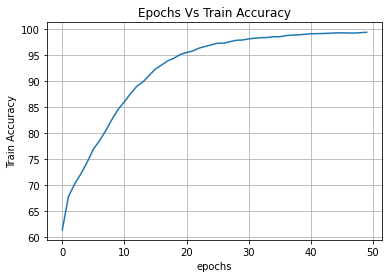

In [22]:
view.show_graph(range(epochs), train_accuracy, "epochs", "Train Accuracy", "Epochs Vs Train Accuracy")

# Epochs & Test Accuracy

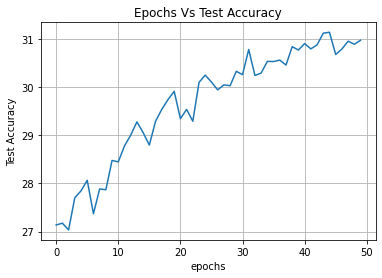

In [23]:
view.show_graph(range(epochs), test_accuracy, "epochs", "Test Accuracy", "Epochs Vs Test Accuracy")